# Aufgabe 3 & 4

### Implementierung der gemischten BasicPRM- und GaussPRM-Verfahren 

Die Vermischung der beiden Verfahren wurden in den Dateien 'sampling_classes.py' und 'sampling_algorithms.py' umgesetzt.
In diesem Notebook findet lediglich das Benchmark statt, um das reine BasicPRM- mit dem gemischten Verfahren zu vergleichen.
Die Problemlösung für Aufgabe 3 ist somit in der Datei 'sampling_class.py' in der Klasse 'BasicGaussianPRM' vorhanden.

### Imports

In [1]:
import sys
sys.path.append("templates")
%load_ext autoreload
%autoreload 2

In [2]:
from IPPerfMonitor import IPPerfMonitor
import IPBasicPRM
import IPVISBasicPRM

import IPBasicGaussian
from sampling_classes import BasicGaussianPRM
from scipy.spatial.distance import euclidean, cityblock
import networkx as nx

### Konfiguration der Testumgebungen

Es werden jeweils 2 verschiedene Konfigurationen der beiden Verfahren getestet mit jeweils 200 und 400 Knoten insgesamt.

In [3]:
plannerFactory = dict()

basicConfig = dict()
basicConfig["radius"] = 3
basicConfig["numNodes"] = 200
plannerFactory["basePRM_200"] = [IPBasicPRM.BasicPRM, basicConfig, IPVISBasicPRM.basicPRMVisualize]

basicConfig2 = dict()
basicConfig2["radius"] = 2.5
basicConfig2["numNodes"] = 400
plannerFactory["basePRM2_400"] = [IPBasicPRM.BasicPRM, basicConfig2, IPVISBasicPRM.basicPRMVisualize]


configBasicGauss = dict()
configBasicGauss["radius"] = 3
configBasicGauss["numNodesBasic"] = 125
configBasicGauss["numNodesGauss"] = 75
configBasicGauss["method"] = 'simple'
plannerFactory["BasicGauss_200"] = [BasicGaussianPRM, configBasicGauss, IPVISBasicPRM.basicGaussPRMVisualize]

configBasicGauss = dict()
configBasicGauss["radius"] = 3
configBasicGauss["numNodesBasic"] = 275
configBasicGauss["numNodesGauss"] = 125
configBasicGauss["method"] = 'simple'
plannerFactory["BasicGauss_400"] = [BasicGaussianPRM, configBasicGauss, IPVISBasicPRM.basicGaussPRMVisualize]

In [4]:
class ResultCollection (object):
    
    def __init__(self, plannerFactoryName, planner, benchmark, solution, perfDataFrame):
        self.plannerFactoryName = plannerFactoryName
        self.planner = planner
        self.benchmark = benchmark
        self.solution = solution
        self.perfDataFrame = perfDataFrame

In [5]:
import IPTestSuite
import importlib

In [6]:
importlib.reload(IPTestSuite)

<module 'IPTestSuite' from 'e:\\Uni\\Roboterprogrammierung\\Roboterprogrammierung_Projektarbeit\\IPTestSuite.py'>

In [7]:
for benchmark in IPTestSuite.benchList:
    print(benchmark.name)

Trap
Bottleneck
Fat bottleneck
Spirals
Entrance
Entrances
KIT
Inside
SSL
Ring
Hemispheres
Hammerhead
Zigzag
Spiral
medium
medium2
L-square
Teeth
Gearshift
Squares_easy
Zigzag_medium
Zigzag_hard
Japan
Haystack
HairPerson
M Sahpe(JM)
Random Field (LB)
stick figure (AA)
Double Circle(JM)
Sun Scribble (FP)
Wpoint (SS)
Points Field (NC)
Hi (TN)
S Field
HKA (SS)
HKA (HKA)
tLines (TK)
U Lines (KA)
Ricos Moderne Kunst
Pillars (MA)
Random Bubbles (MS)
Point Matrix (CH)
VFB (LD)
Face (JS)
Maze (AZ)
Robo (FP)
Stickman (MK)
House (AZ)
2030+ (2030+)
Random Bubbles (MS)


### Benchmarks durchführen

In [8]:
resultList = list()

for key,producer in list(plannerFactory.items()):
    print(key, producer)
    for benchmark in IPTestSuite.benchList:
        print ("Planning: " + key + " - " + benchmark.name)
        #planner = IPBasicPRM.BasicPRM(benchmark.collisionChecker)
        planner = producer[0](benchmark.collisionChecker)
        IPPerfMonitor.clearData()
        try:
            
            resultList.append(ResultCollection(key,
                                            planner, 
                                            benchmark, 
                                            planner.planPath(benchmark.startList,benchmark.goalList,producer[1]),
                                            IPPerfMonitor.dataFrame()
                                            ),
                        )
        except Exception as e:
            print ("PLANNING ERROR ! PLANNING ERROR ! PLANNING ERROR ")
            pass

basePRM_200 [<class 'IPBasicPRM.BasicPRM'>, {'radius': 3, 'numNodes': 200}, <function basicPRMVisualize at 0x0000019E8AFDA940>]
Planning: basePRM_200 - Trap
Planning: basePRM_200 - Bottleneck
PLANNING ERROR ! PLANNING ERROR ! PLANNING ERROR 
Planning: basePRM_200 - Fat bottleneck
Planning: basePRM_200 - Spirals
Planning: basePRM_200 - Entrance
Planning: basePRM_200 - Entrances
Planning: basePRM_200 - KIT
Planning: basePRM_200 - Inside
Planning: basePRM_200 - SSL
Planning: basePRM_200 - Ring
Planning: basePRM_200 - Hemispheres
Planning: basePRM_200 - Hammerhead
Planning: basePRM_200 - Zigzag
Planning: basePRM_200 - Spiral
Planning: basePRM_200 - medium
Planning: basePRM_200 - medium2
Planning: basePRM_200 - L-square
Planning: basePRM_200 - Teeth
Planning: basePRM_200 - Gearshift
Planning: basePRM_200 - Squares_easy
Planning: basePRM_200 - Zigzag_medium
Planning: basePRM_200 - Zigzag_hard
Planning: basePRM_200 - Japan
Planning: basePRM_200 - Haystack
Planning: basePRM_200 - HairPerson
Pl

In [9]:
print(plannerFactory.items())

dict_items([('basePRM_200', [<class 'IPBasicPRM.BasicPRM'>, {'radius': 3, 'numNodes': 200}, <function basicPRMVisualize at 0x0000019E8AFDA940>]), ('basePRM2_400', [<class 'IPBasicPRM.BasicPRM'>, {'radius': 2.5, 'numNodes': 400}, <function basicPRMVisualize at 0x0000019E8AFDA940>]), ('BasicGauss_200', [<class 'sampling_classes.BasicGaussianPRM'>, {'radius': 3, 'numNodesBasic': 125, 'numNodesGauss': 75, 'method': 'simple'}, <function basicGaussPRMVisualize at 0x0000019E8BD63820>]), ('BasicGauss_400', [<class 'sampling_classes.BasicGaussianPRM'>, {'radius': 3, 'numNodesBasic': 275, 'numNodesGauss': 125, 'method': 'simple'}, <function basicGaussPRMVisualize at 0x0000019E8BD63820>])])


### Benchmark-Grafiken plotten

In [10]:
import matplotlib.pyplot as plt

plt.pyplot.rcdefaults()

for result in resultList:
    
    fig_local = plt.figure(figsize=(20 ,20))
    ax = fig_local.add_subplot(1,1,1)
    title = result.plannerFactoryName + " - " + result.benchmark.name
    if result.solution == []:
        title += " (No path found!)"
    title += "\n Assumed complexity level " + str(result.benchmark.level)
    ax.set_title(title)
    try:
        #IPVISBasicsPRM.basicPRMVisualize(result.planner, result.solution, ax=ax, nodeSize=100))
        plannerFactory[result.plannerFactoryName][2](result.planner, result.solution, ax=ax, nodeSize=100)
    except:
        print("Exception")
        pass

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

### Benchmark-Diagramme plotten

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 100

C:\Users\Philipp\AppData\Local\Temp/ipykernel_5700/3859746743.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


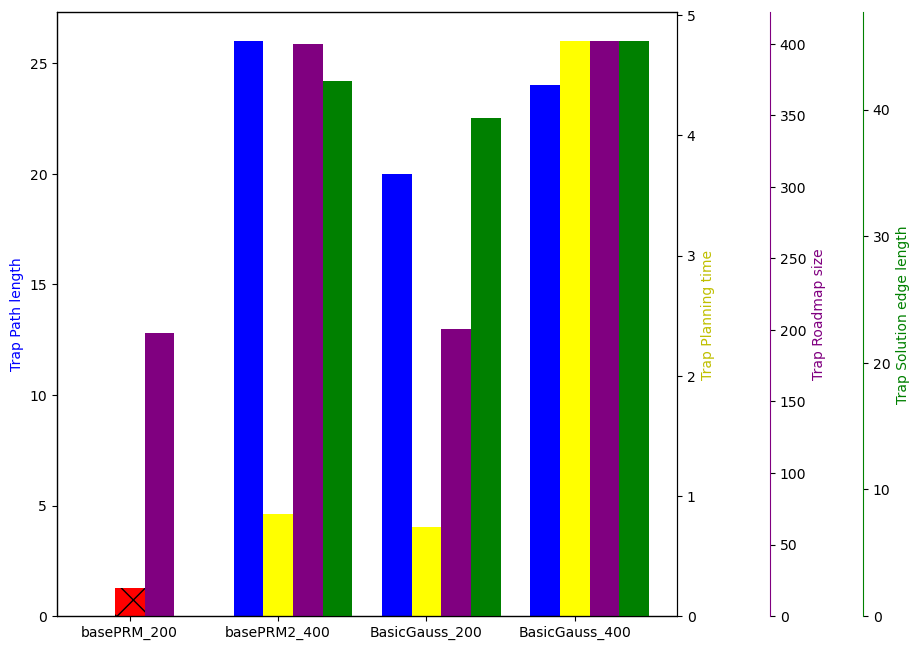

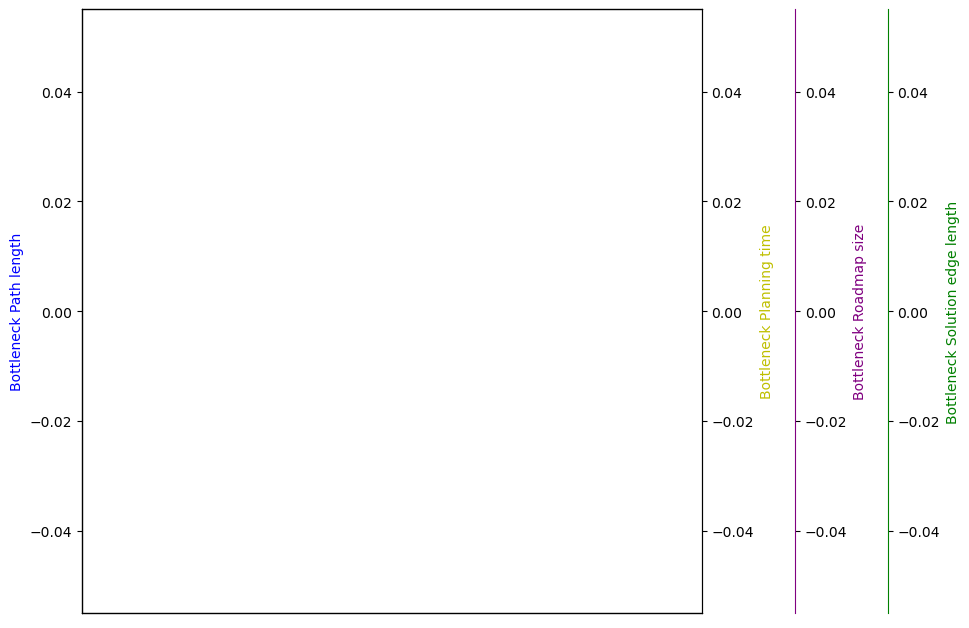

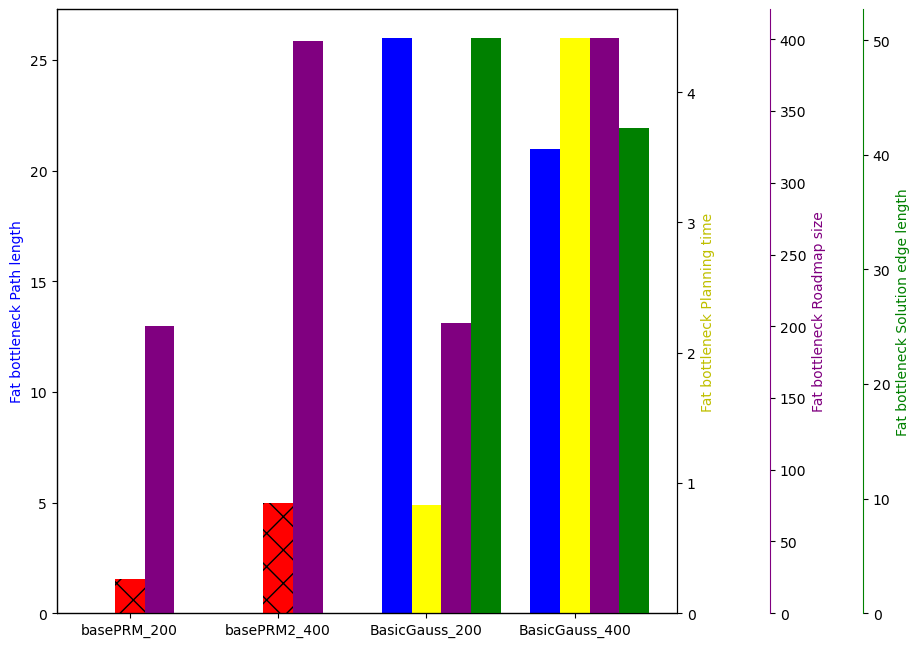

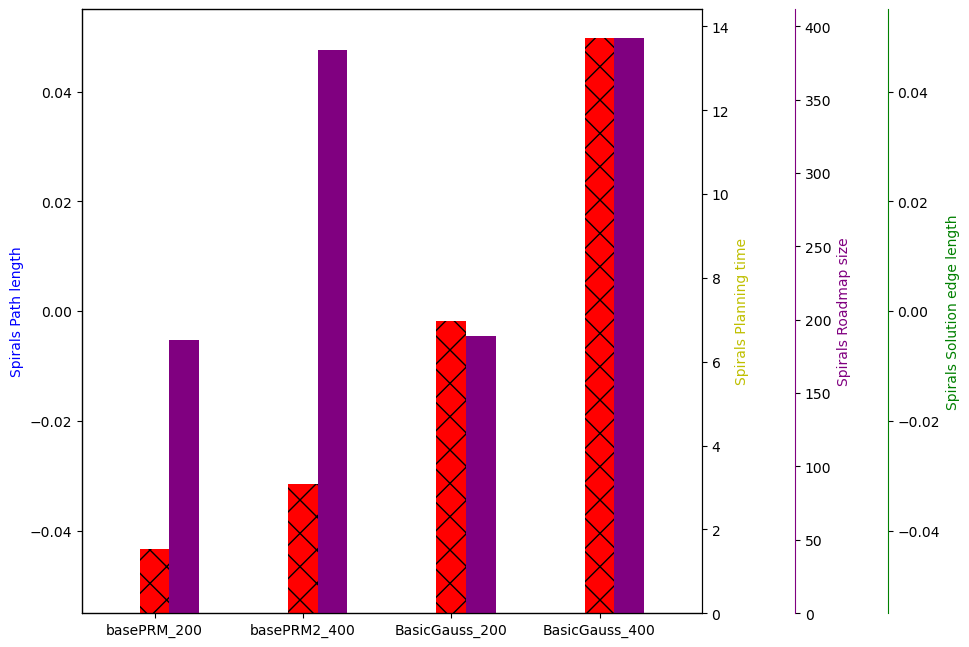

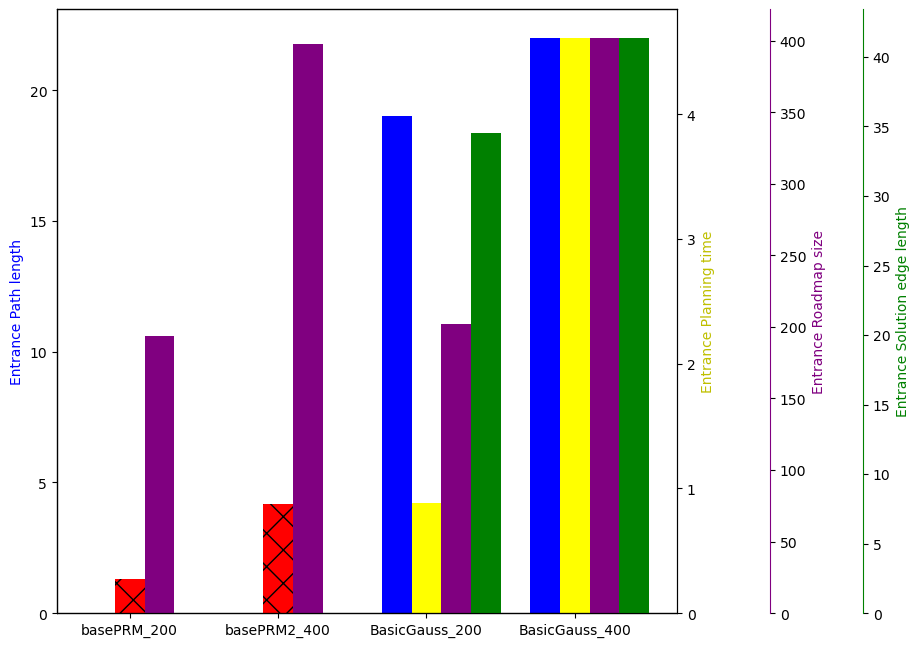

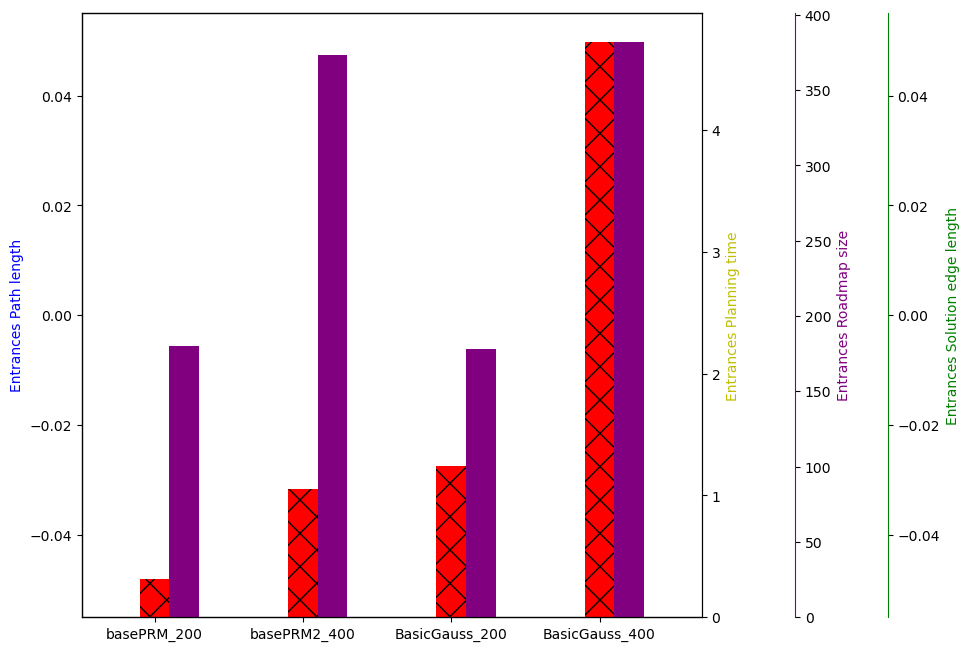

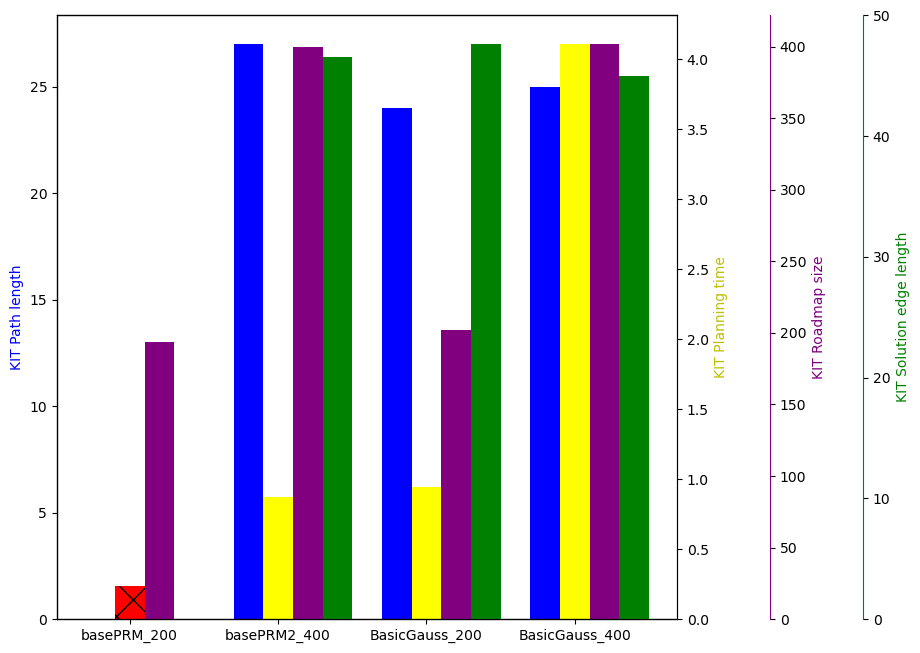

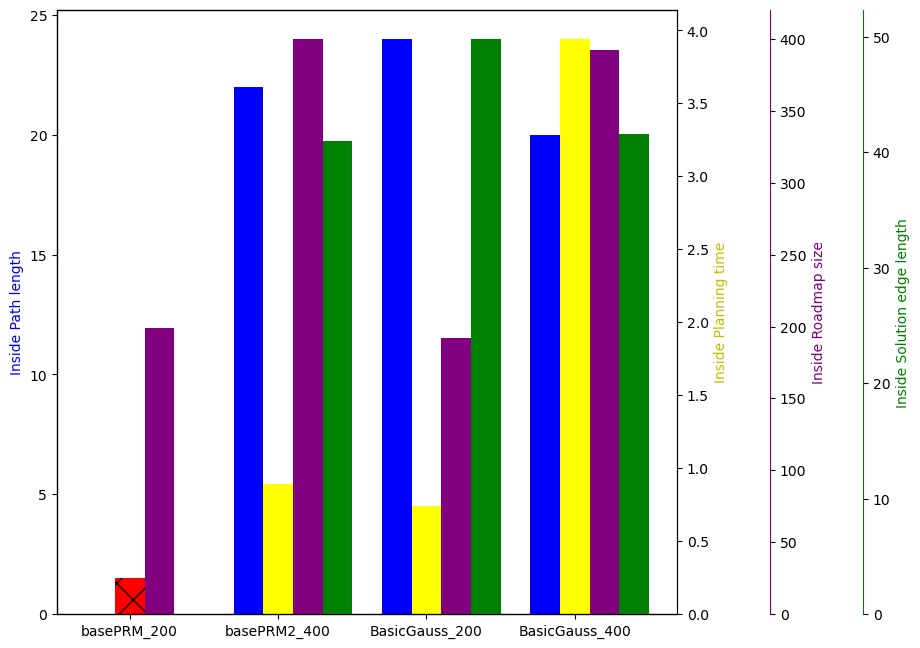

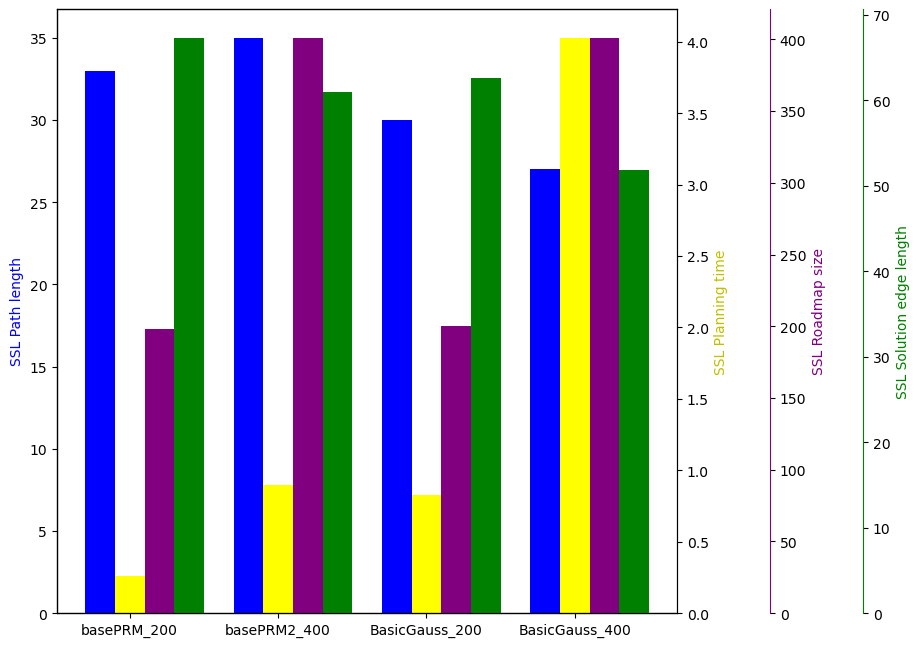

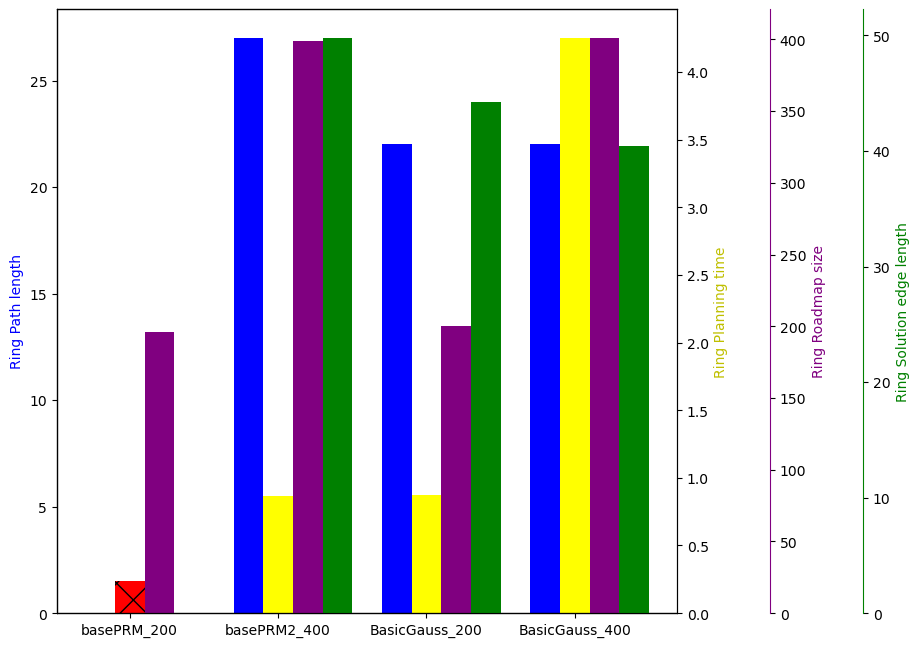

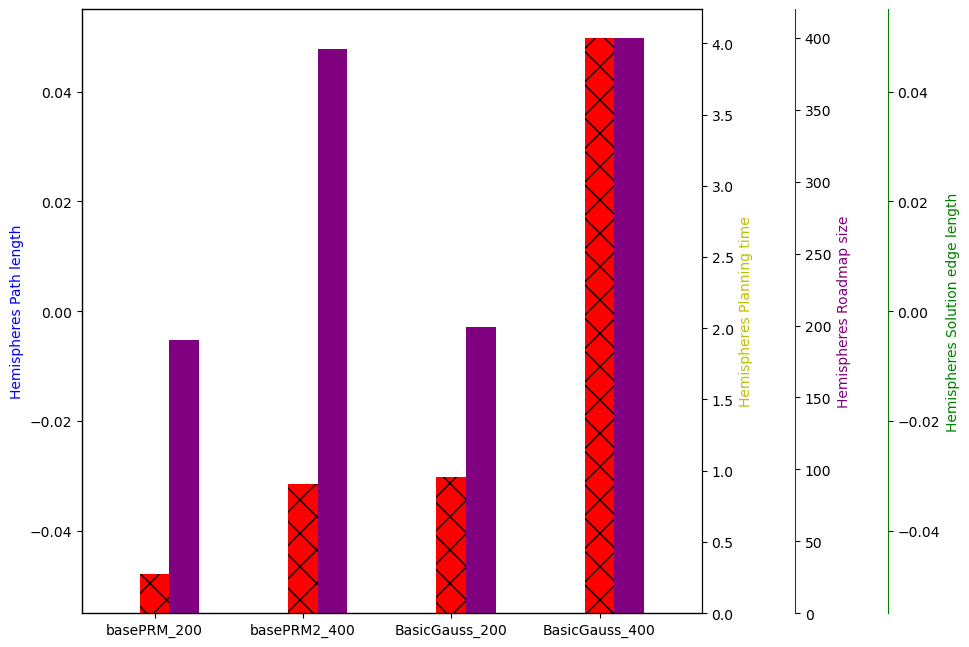

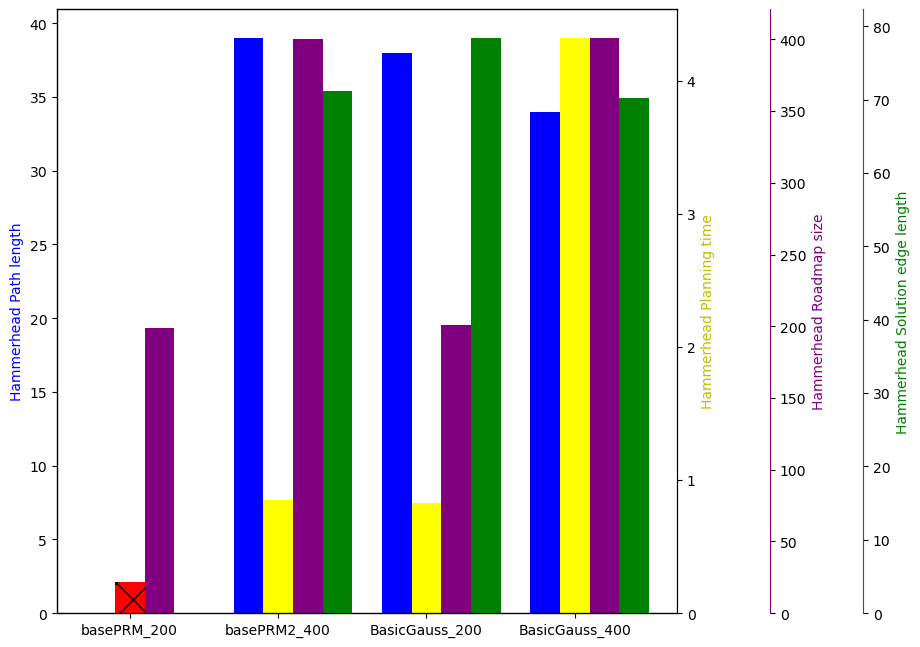

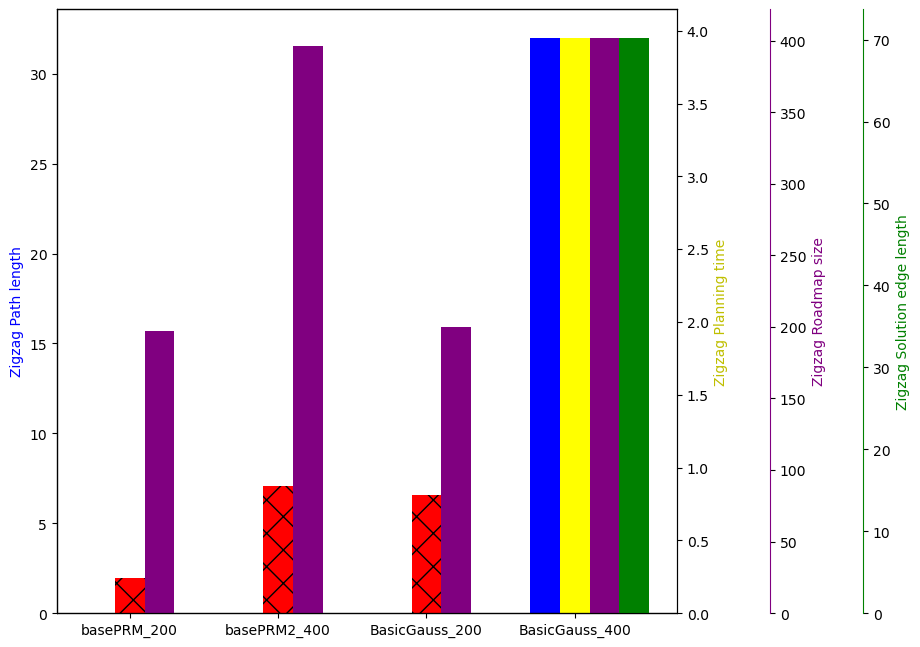

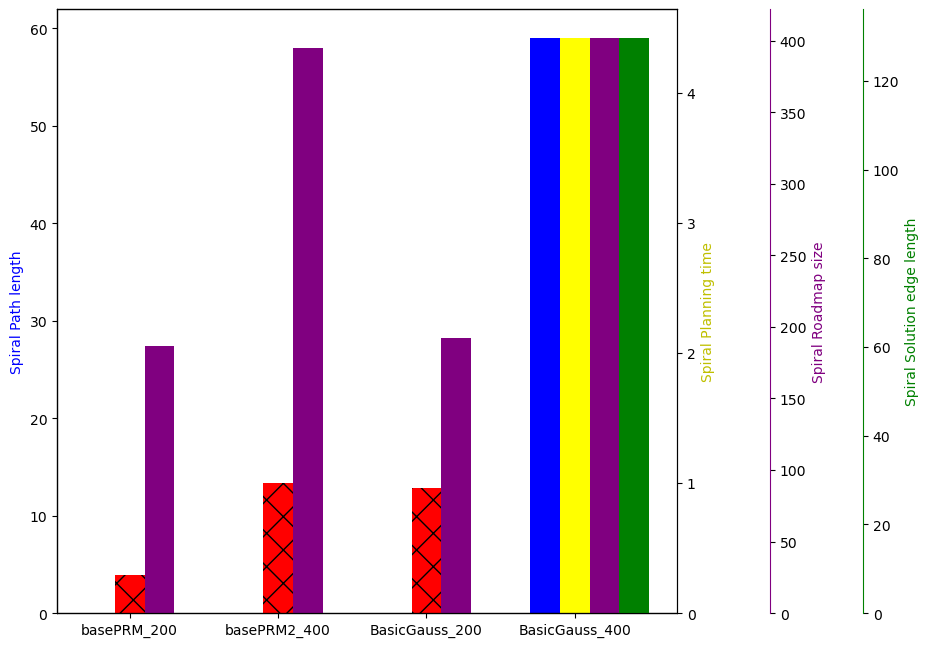

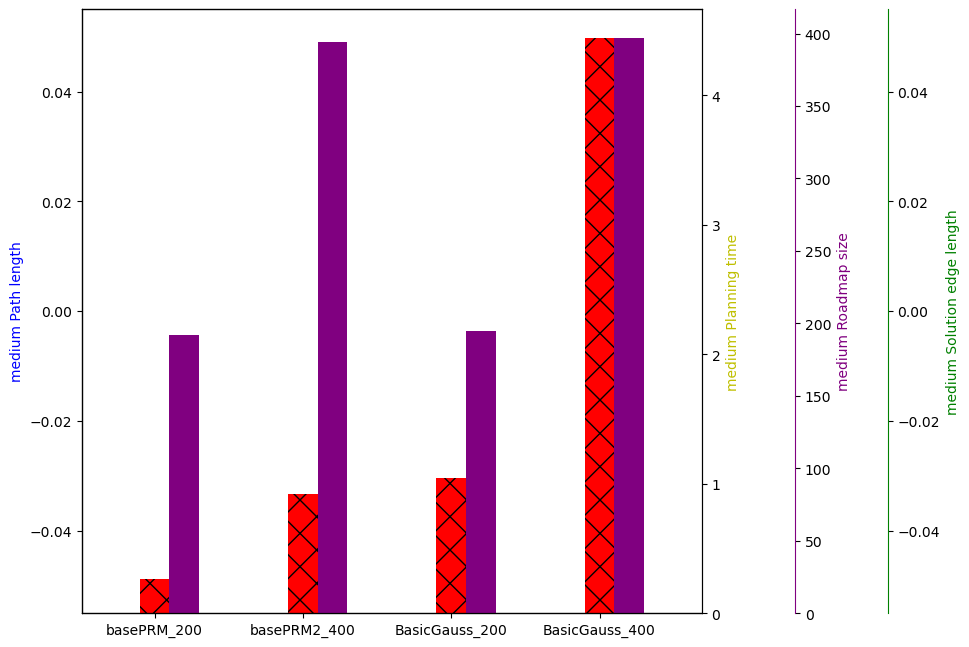

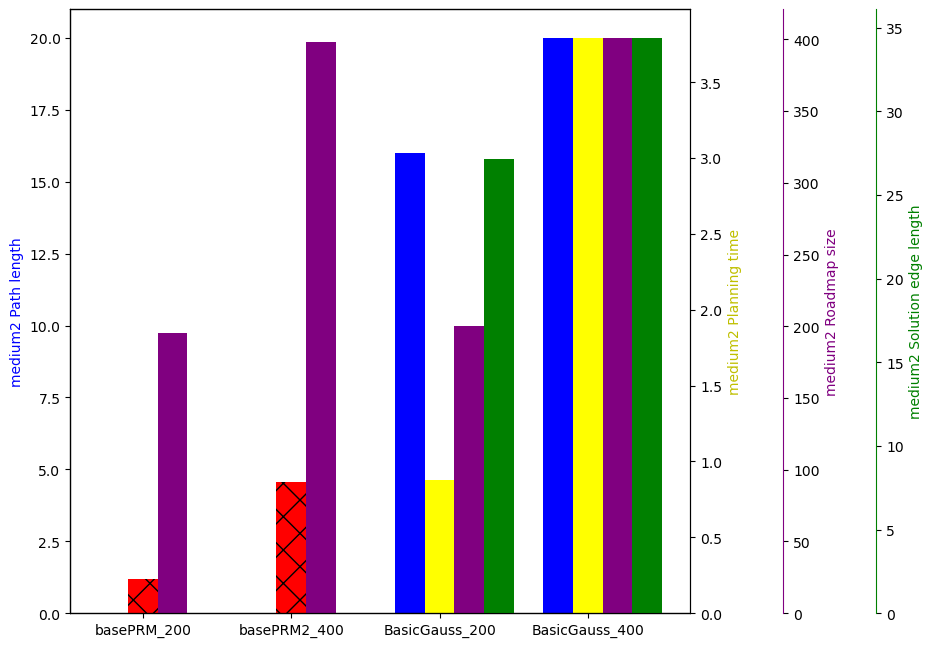

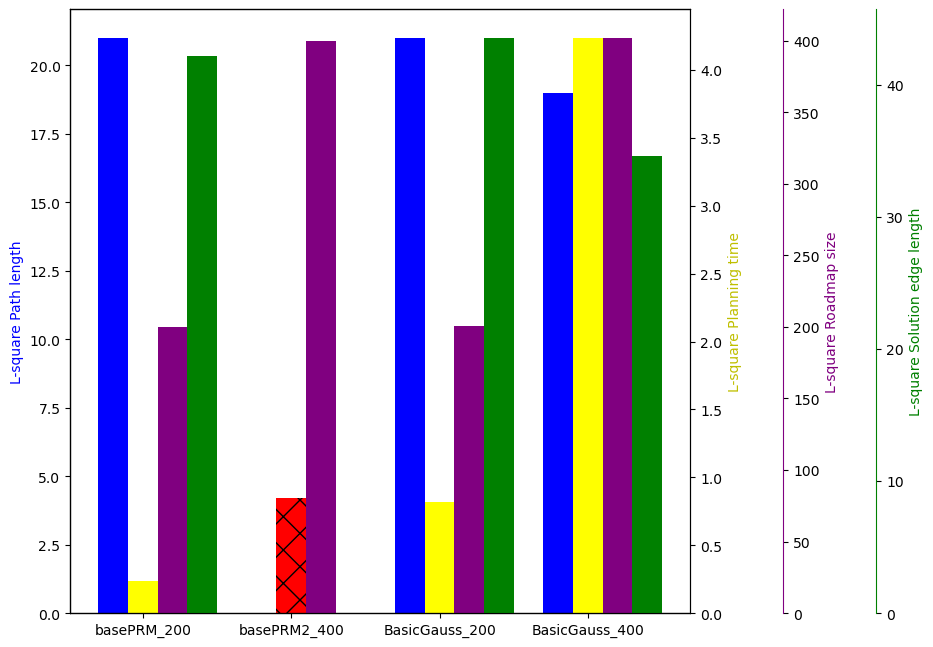

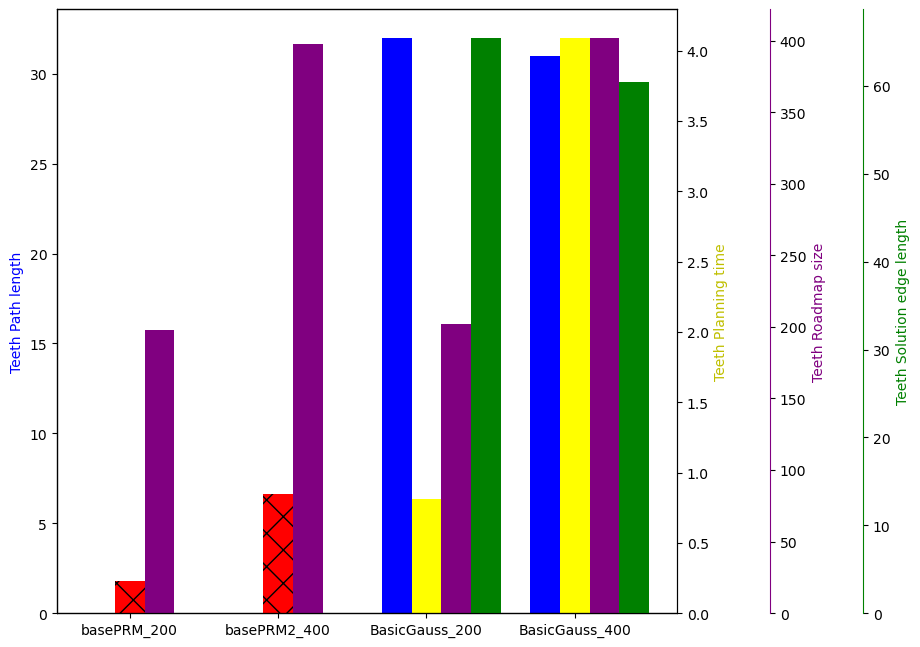

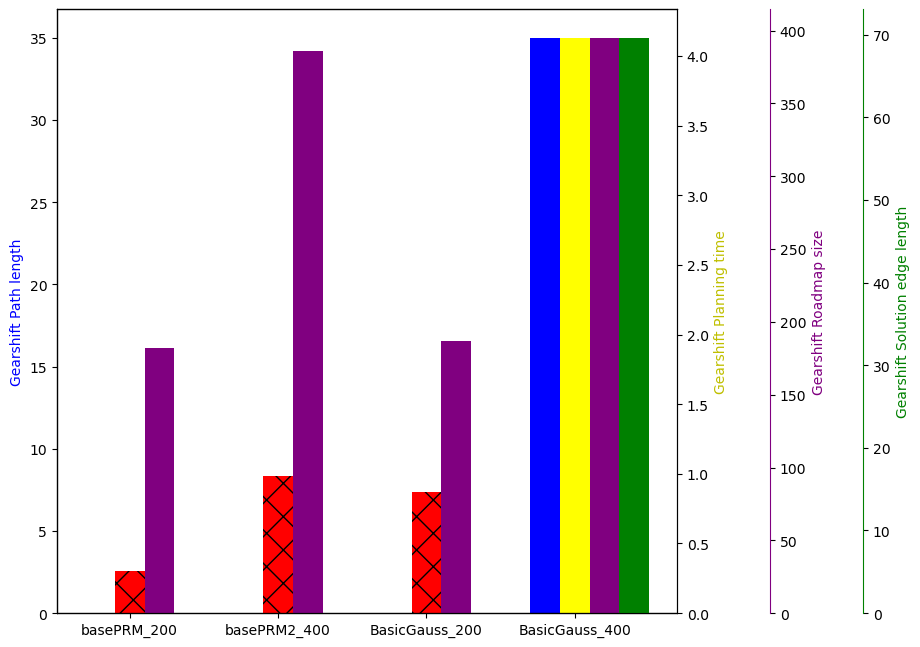

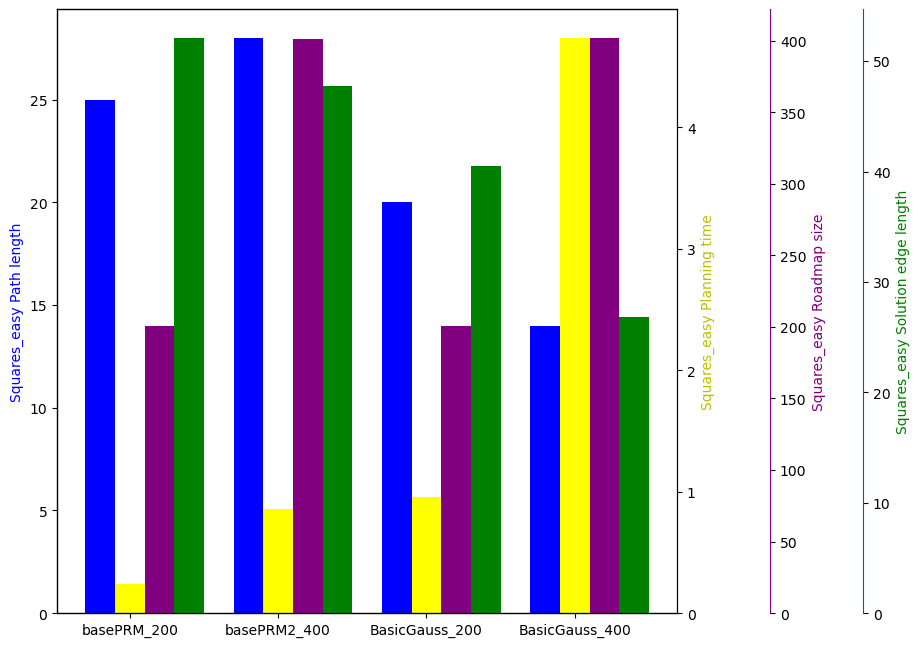

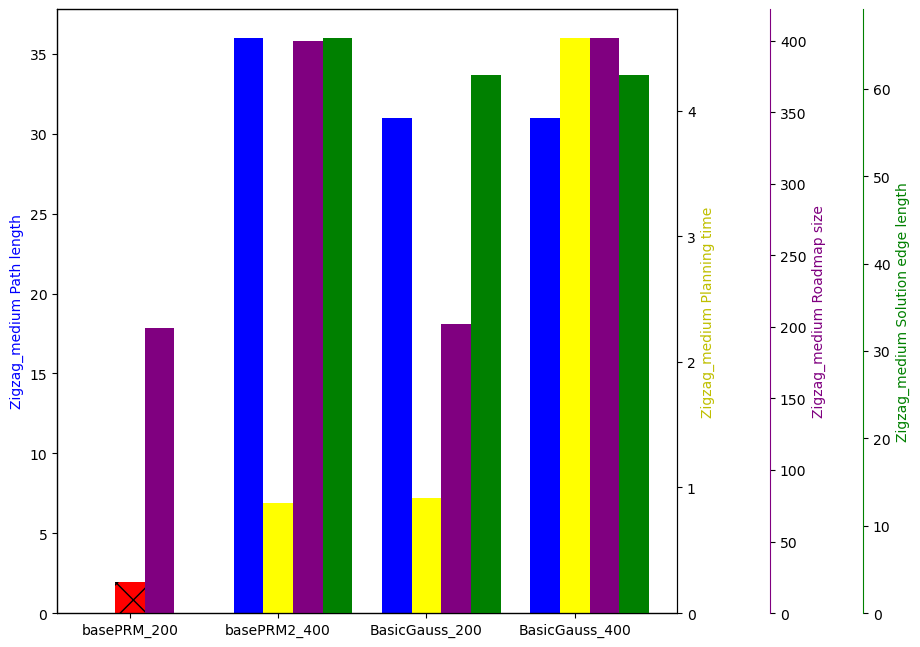

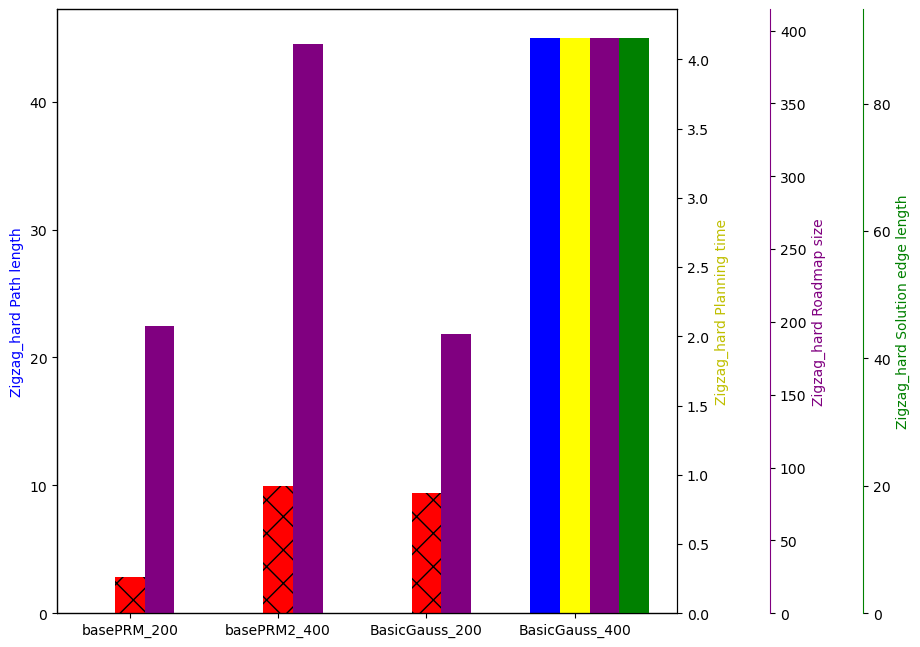

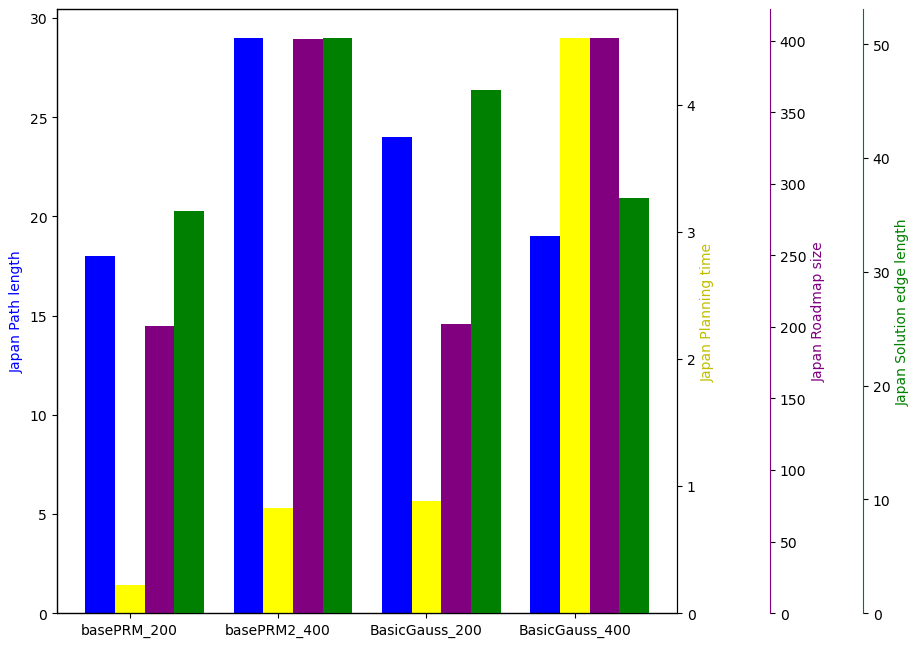

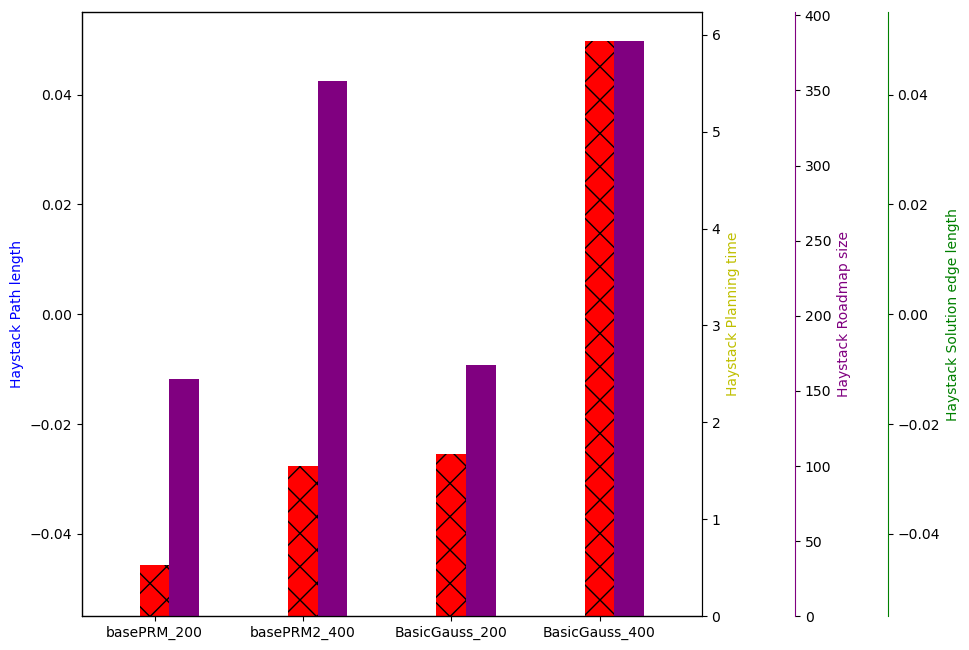

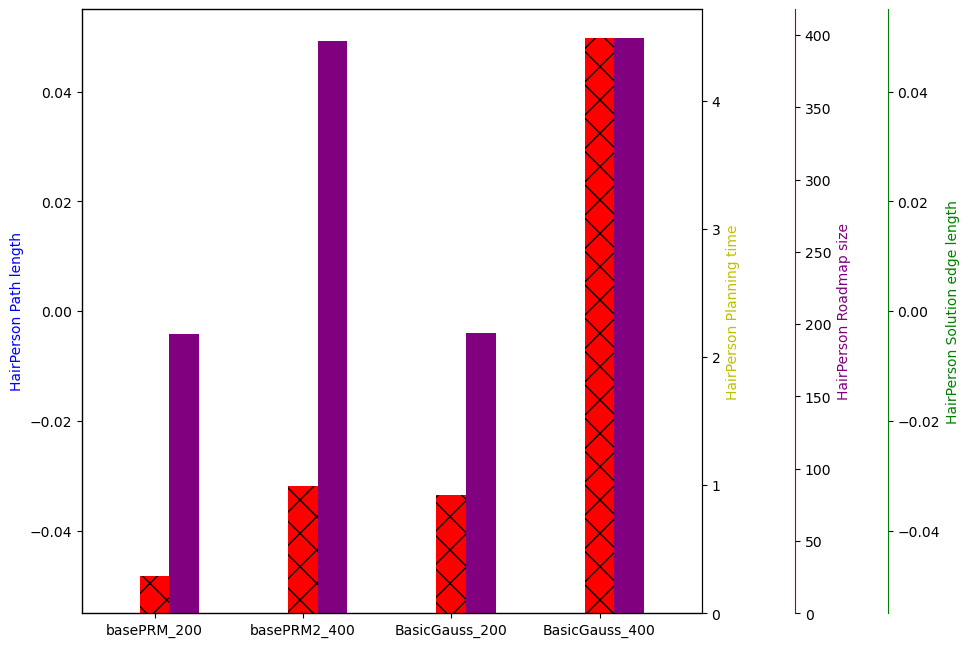

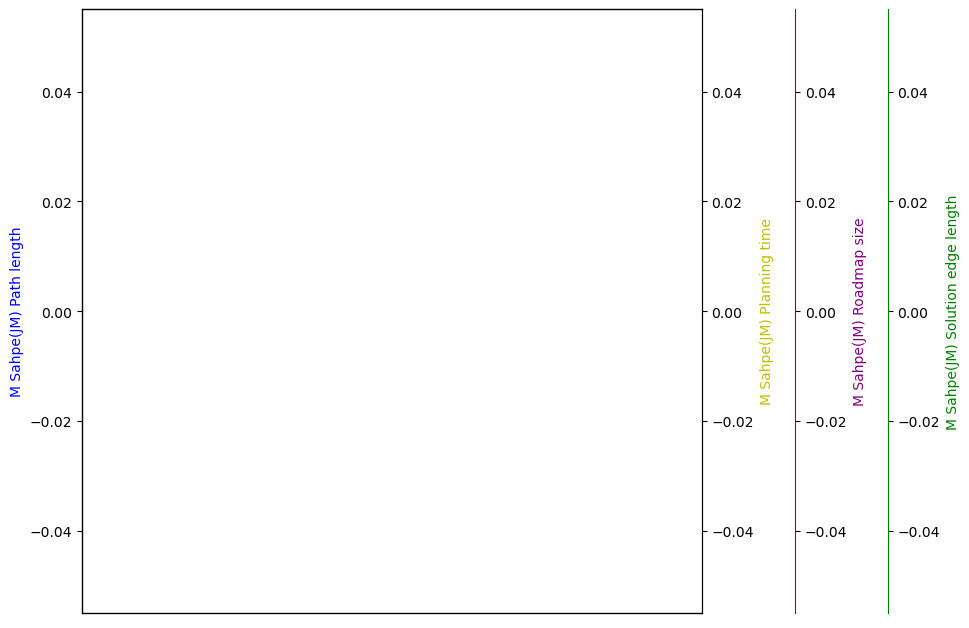

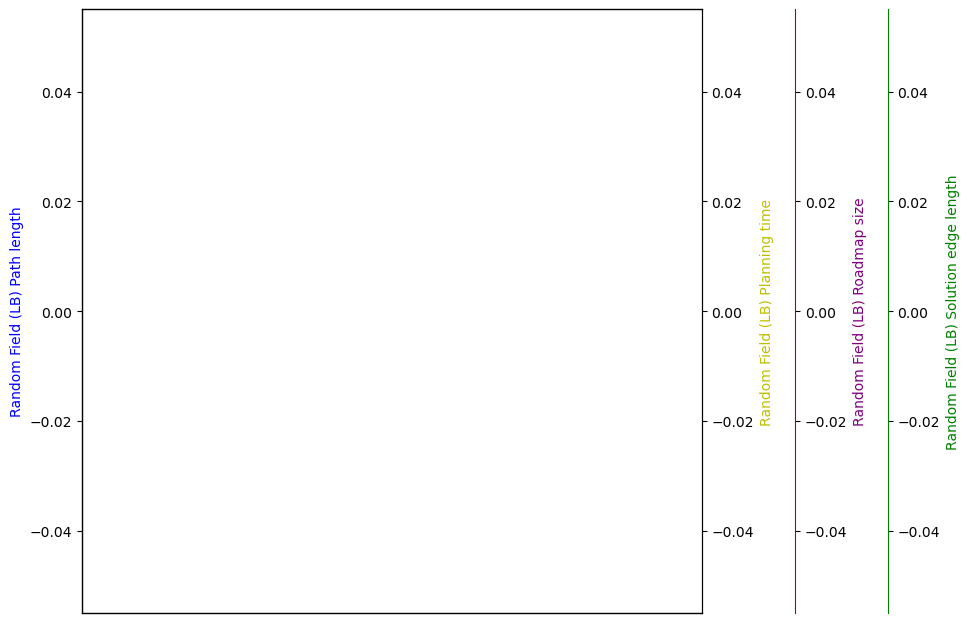

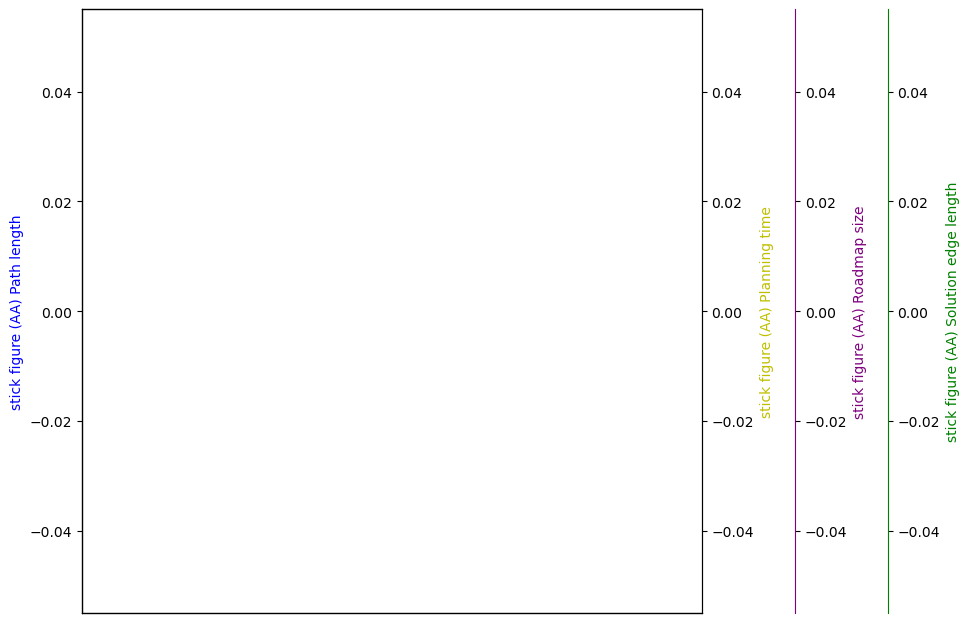

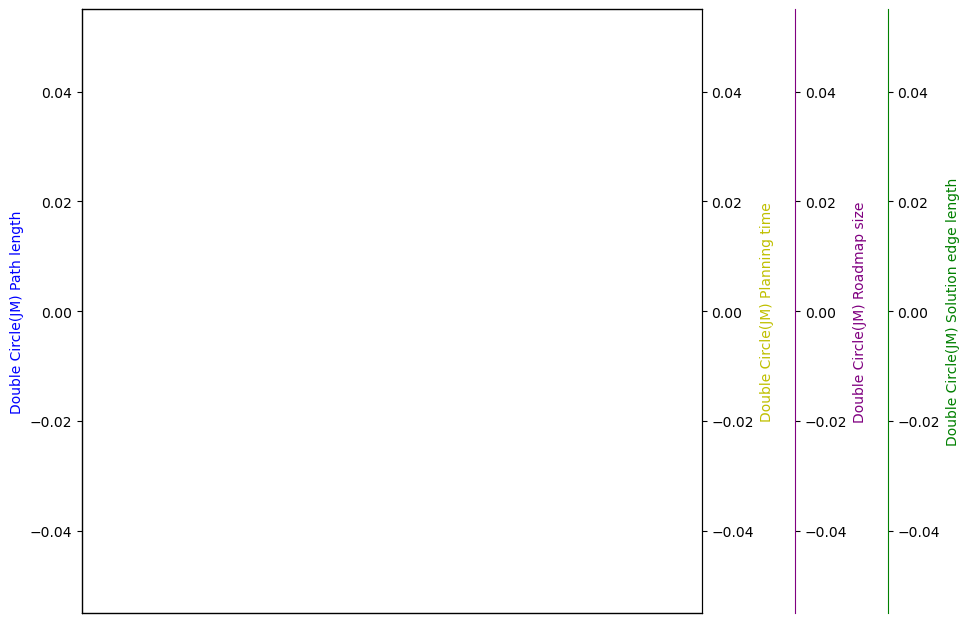

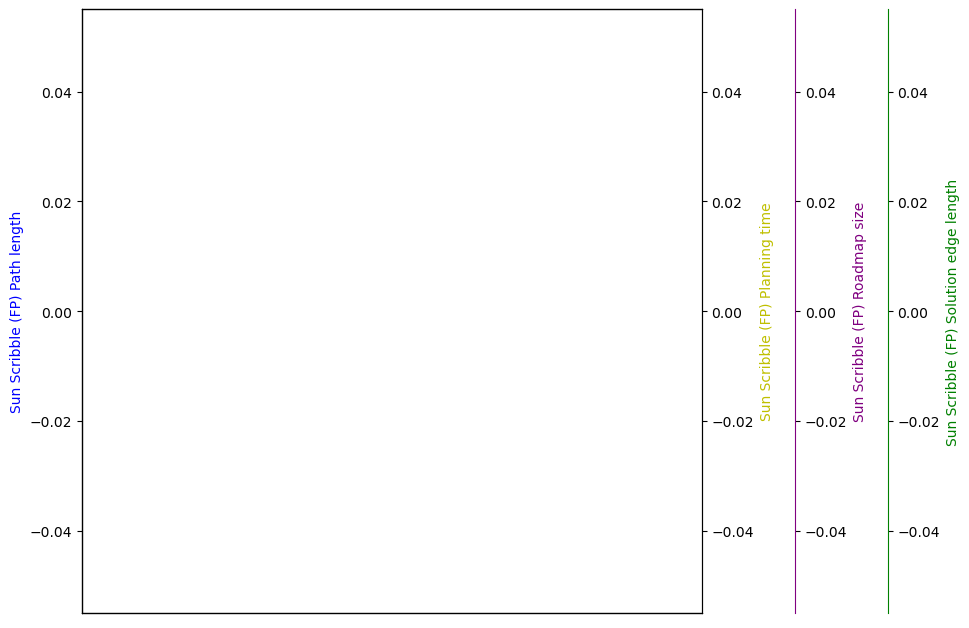

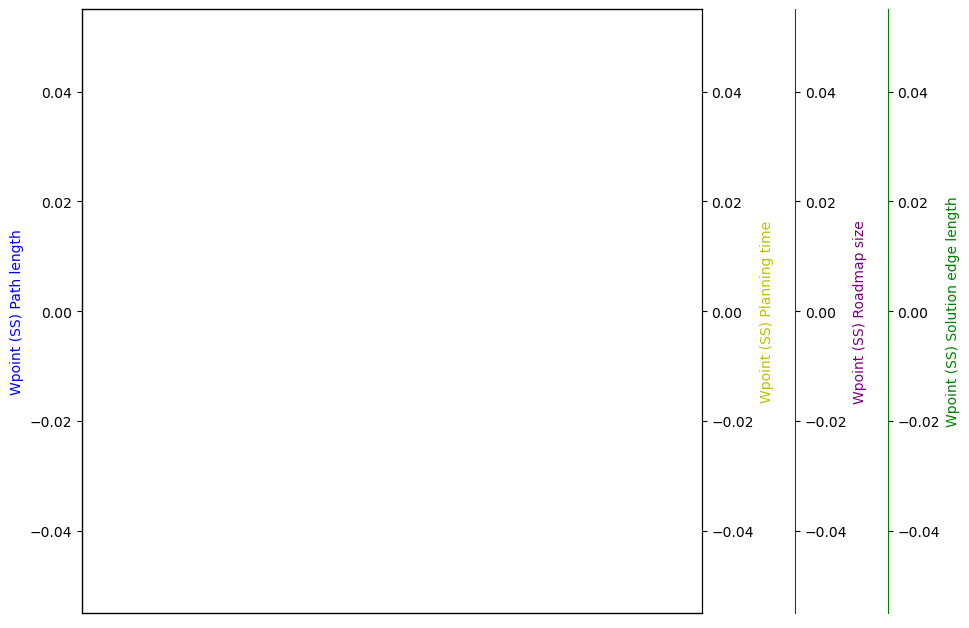

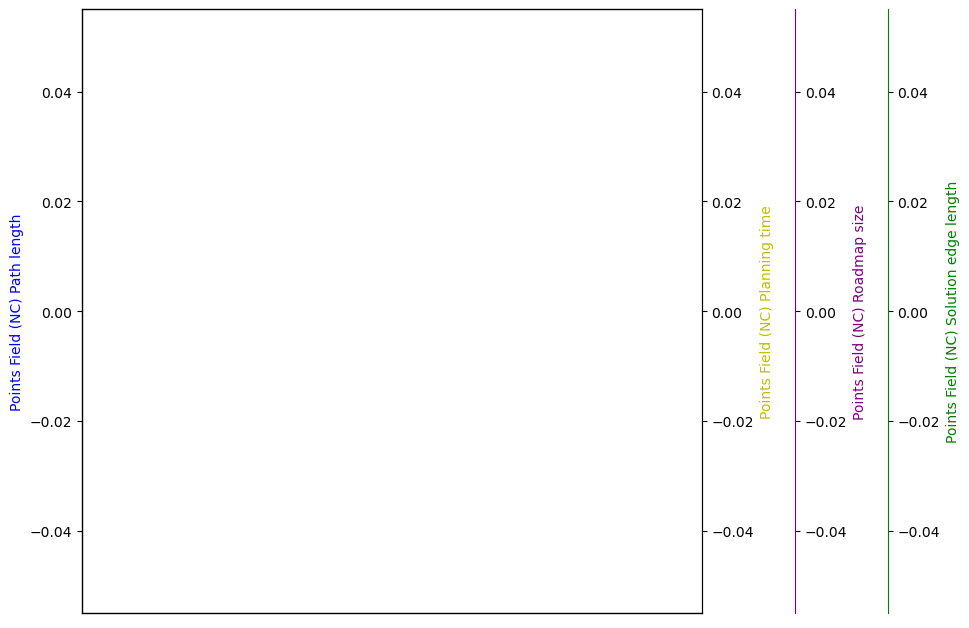

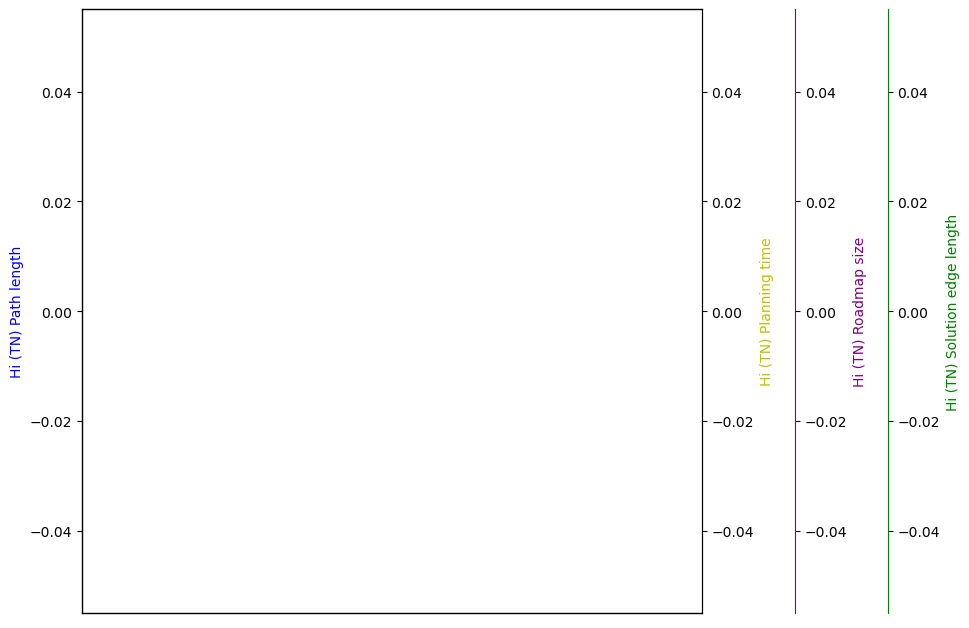

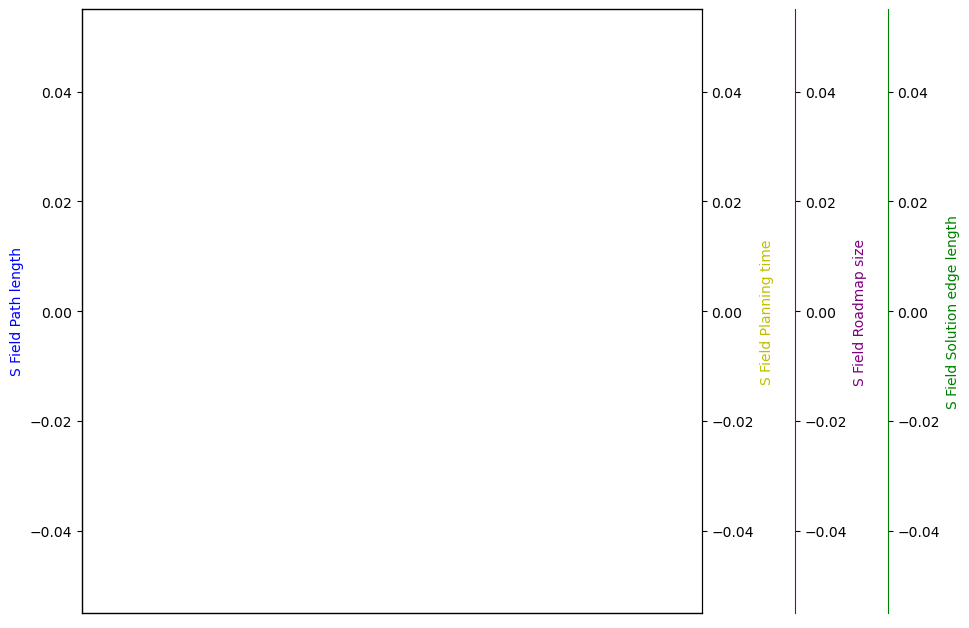

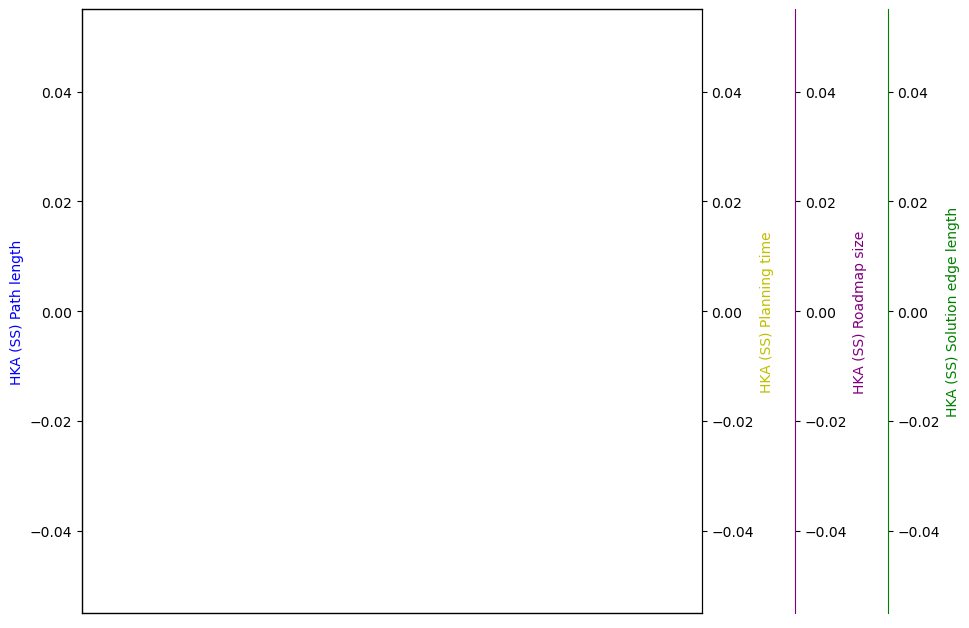

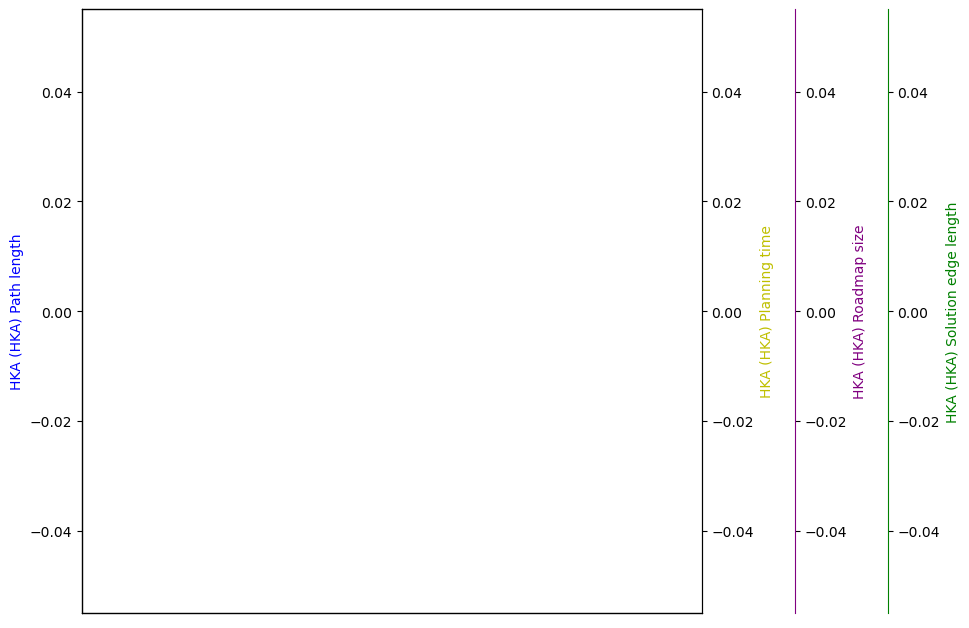

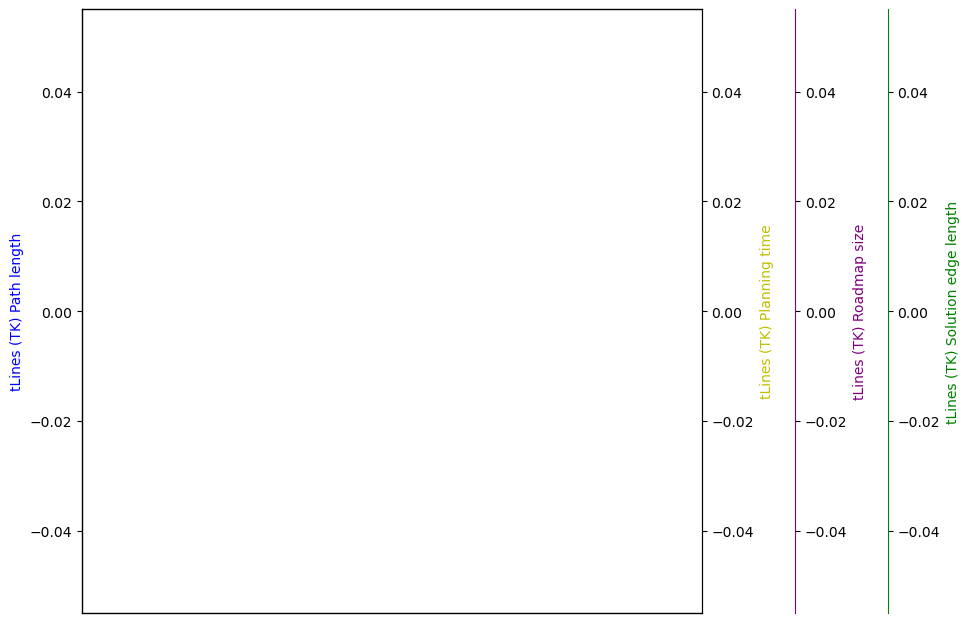

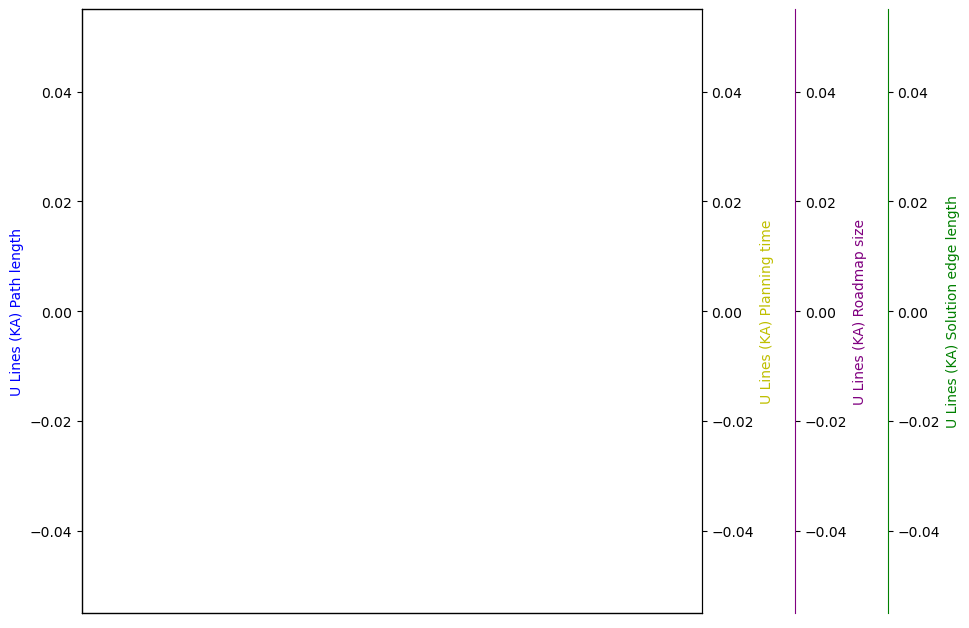

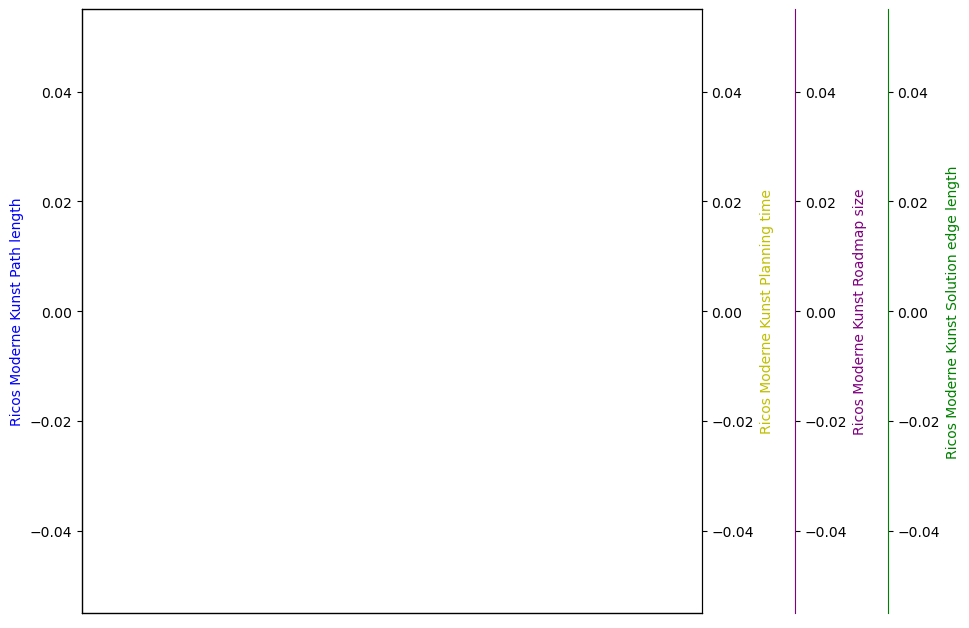

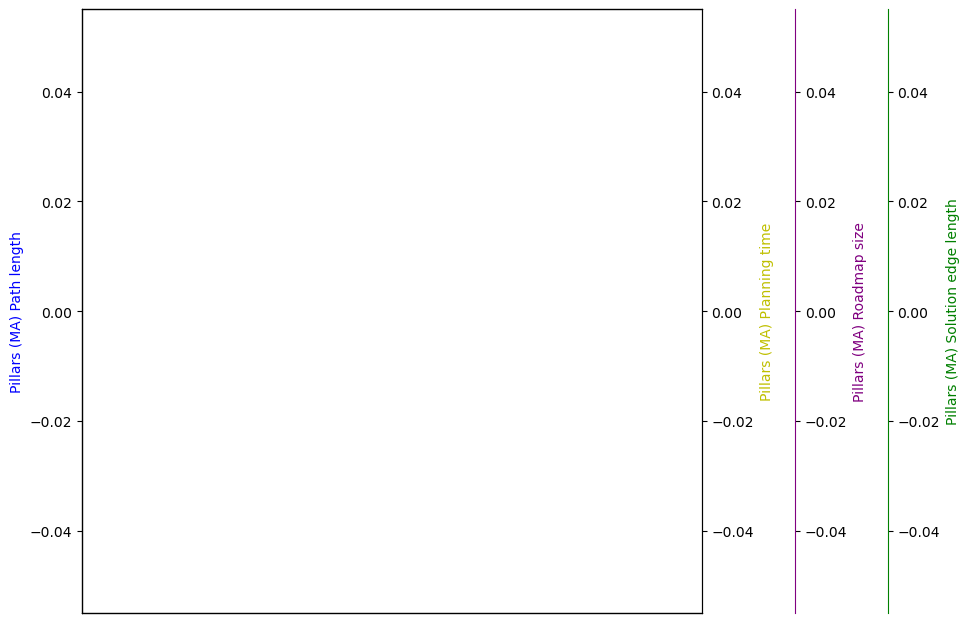

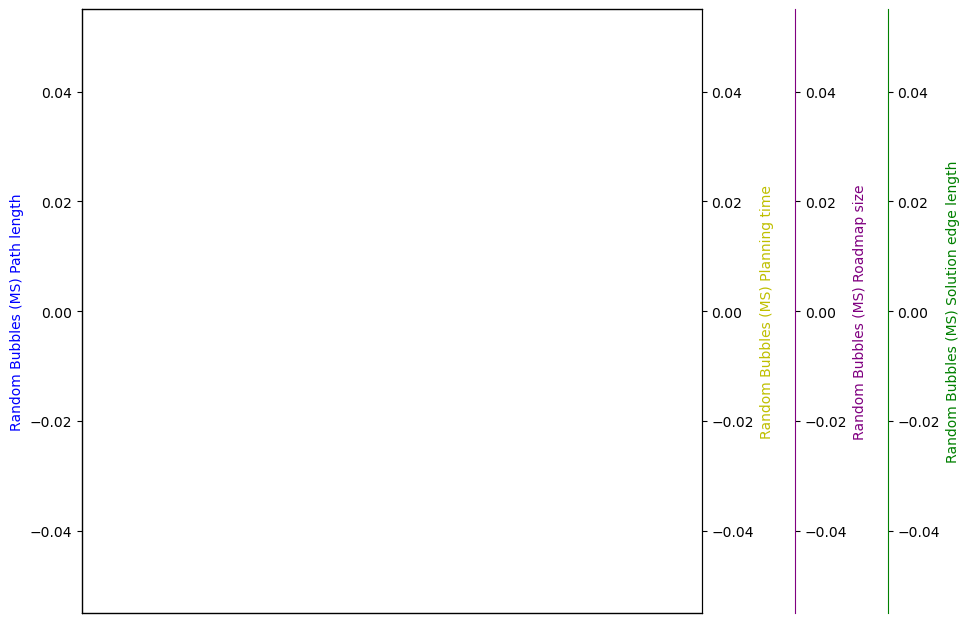

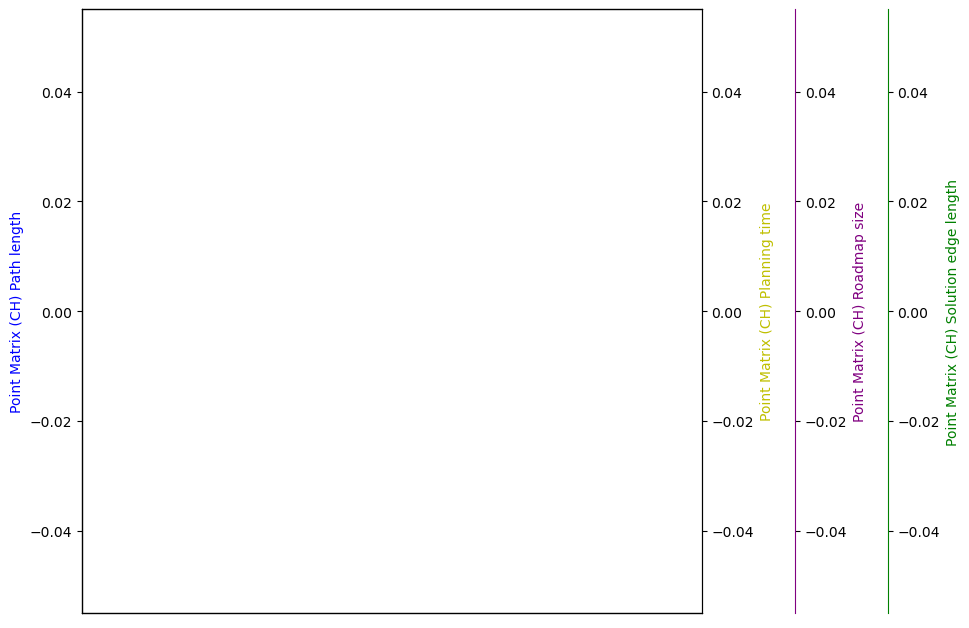

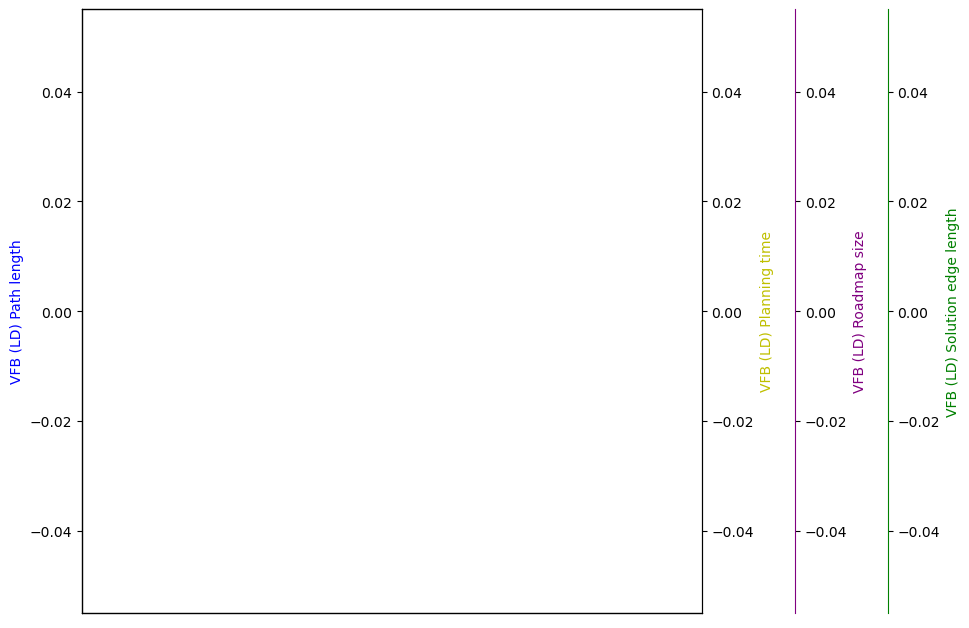

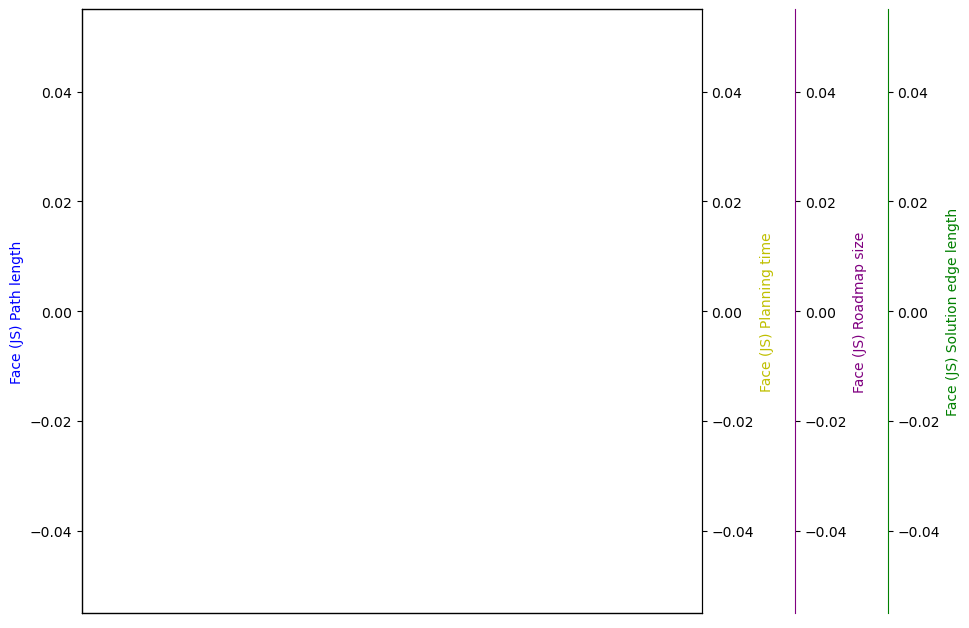

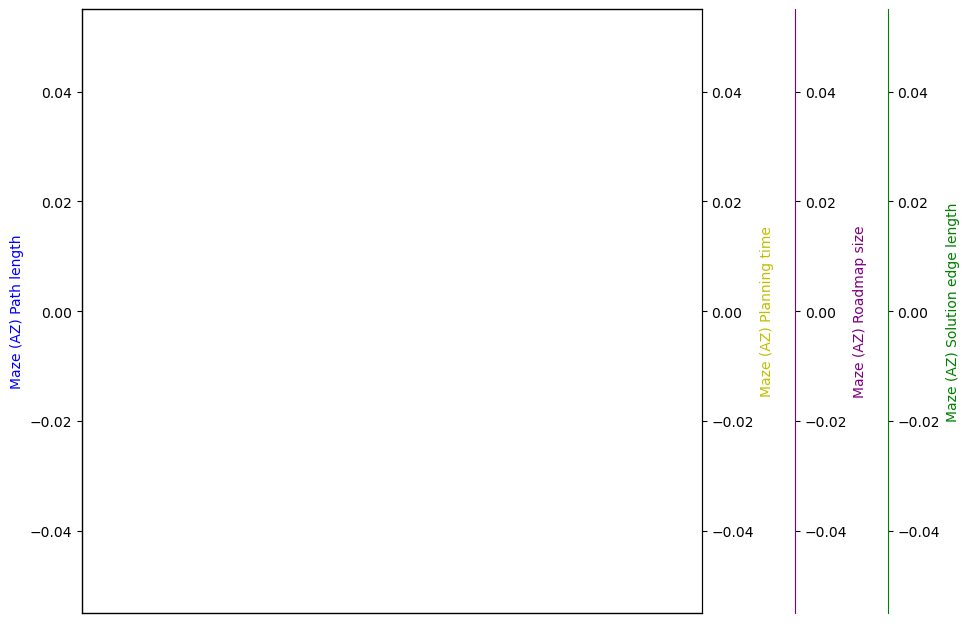

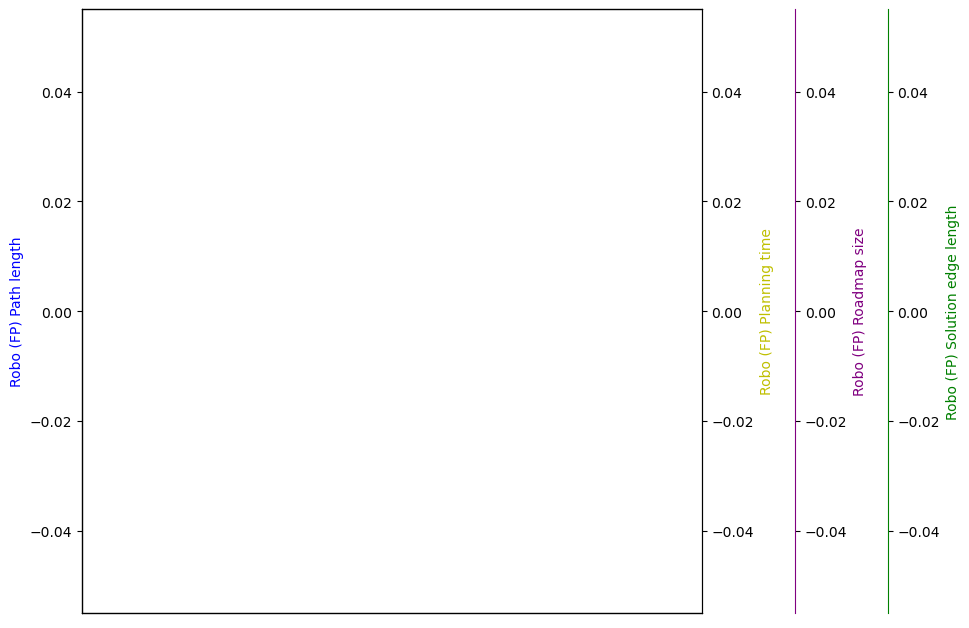

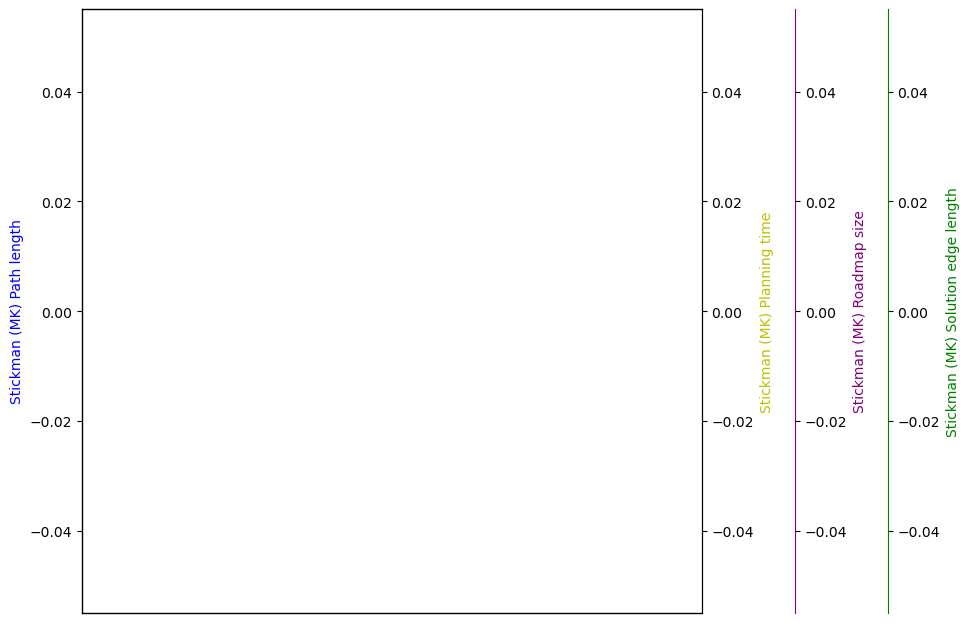

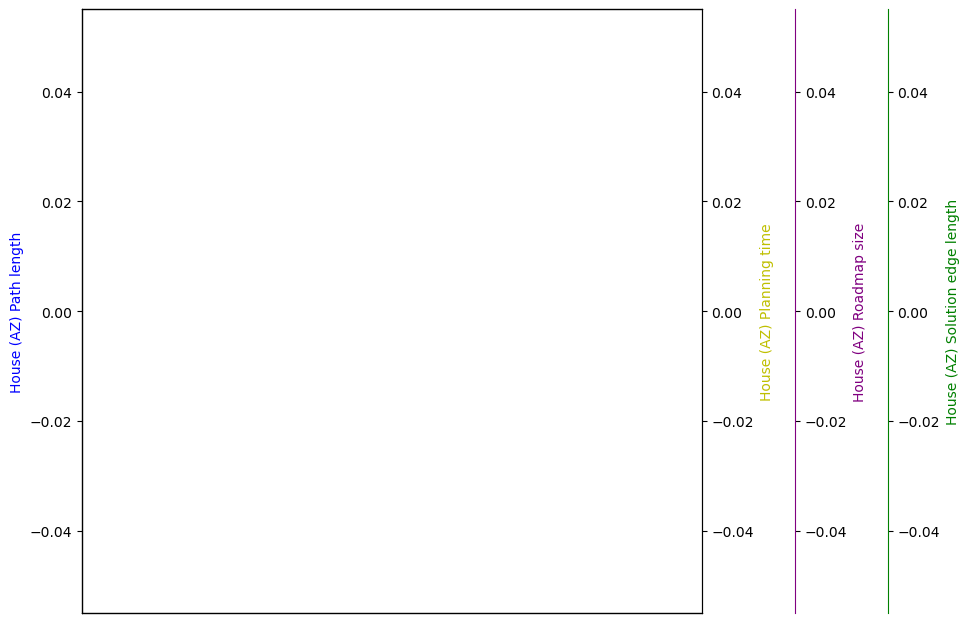

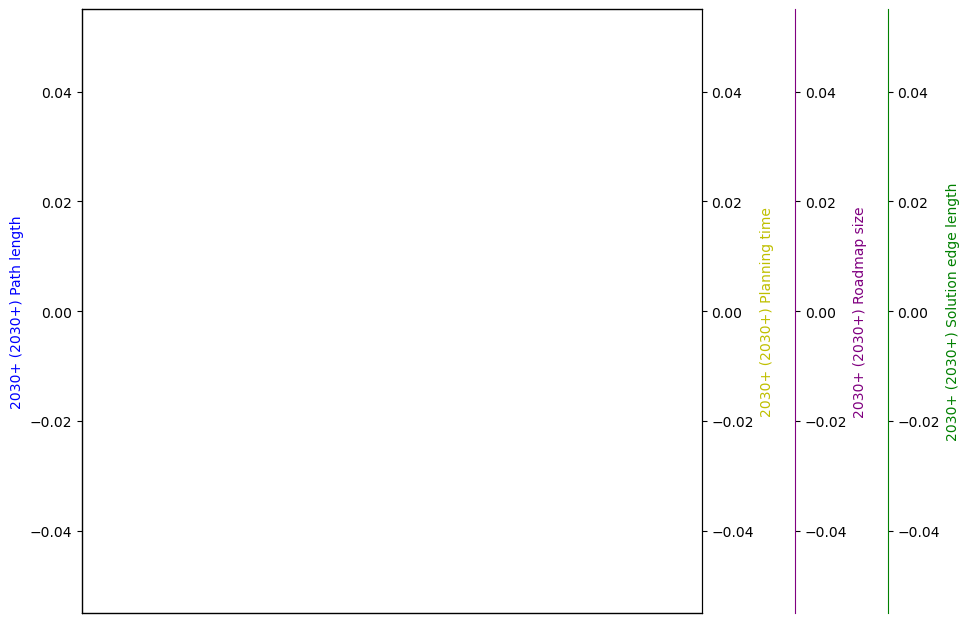

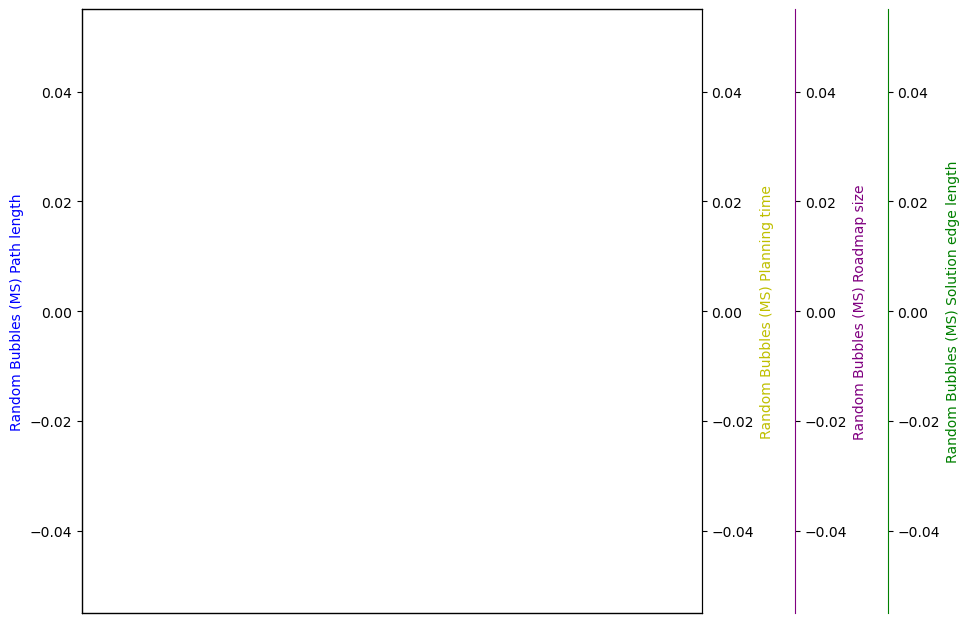

In [ ]:
import numpy as np
for bench in IPTestSuite.benchList:
    title = bench.name
    pathLength = dict()
    planningTime = dict()
    roadmapSize  = dict()
    edgeLength = dict()
    
    for result in resultList:
        if result.benchmark.name == bench.name:
            #print result.benchmark.name  + " - " + result.plannerFactoryName, len(result.solution)
            edgeLength[result.plannerFactoryName] = sum([euclidean(result.planner.graph.nodes()[current]['pos'], result.planner.graph.nodes()[previous]['pos']) for previous, current in zip(result.solution, result.solution[1:])])
            pathLength[result.plannerFactoryName] = len(result.solution)
            planningTime[result.plannerFactoryName] = result.perfDataFrame.groupby(["name"]).sum()["time"]["planPath"]
            roadmapSize[result.plannerFactoryName] = result.planner.graph.size()
    
    
    fig, ax = plt.subplots()
    
    width = 0.2

    ax.bar(np.arange(len(pathLength.keys())), pathLength.values(),width, color="blue")
    ax.set_ylabel(title + " Path length", color="blue")
    ax.set_xticks(np.arange(len(pathLength.keys())) + width)
    ax.set_xticklabels(pathLength.keys())

    ax2 = ax.twinx()
    bar = ax2.bar(np.arange(len(pathLength.keys()))+width, planningTime.values(),width, color="red")
    ax2.set_ylabel(title + " Planning time", color="y")

    # Add coloring and patterns on axis two
    hatches = ['x' if length==0 else '' for length in pathLength.values()]
    color   = ['red' if length==0 else 'yellow' for length in pathLength.values()]
    for i,thisbar in enumerate(bar.patches):
        thisbar.set_facecolor(color[i])
        thisbar.set_hatch(hatches[i])

    # Multiple axes 
    ax3 = ax.twinx()
    ax3.bar(np.arange(len(pathLength.keys()))+2*width, roadmapSize.values(),width, color="purple")
    ax3.set_ylabel(title + " Roadmap size",  color="purple")
    ax3.spines['right'].set_position(('axes', 1.15))
    ax3.spines['right'].set_color("purple")

    ax4 = ax.twinx()
    ax4.bar(np.arange(len(edgeLength.keys()))+3*width, edgeLength.values(),width, color="green")
    ax4.set_ylabel(title + " Solution edge length",  color="green")
    ax4.spines['right'].set_position(('axes', 1.30))
    ax4.spines['right'].set_color("green")

In [ ]:
result.perfDataFrame.groupby(["name"]).sum()["time"]

name
_getRandomFreePosition           0.057040
_inSameConnectedComponent        2.446729
_learnRoadmapNearestNeighbour    4.480859
_nearestNeighboursX              1.547577
lineInCollision                  0.133915
planPath                         4.489785
pointInCollision                 0.284703
Name: time, dtype: float64